# Tutorial: ML Tools and Techniques

This tutorial explores different tools and techniques for writting your own neural networks. We will cover the following topics:

1. ML overview
    * Types of machine learning: supervised vs unsupervised
    * Types of ML problems: regression vs classification 

2. Key concepts
    * Tensor as data representation
    * Data processing: train-test-split, dataset and dataloader.
    * DNN Layers: input, hidden, activation
    * Loss functions and back propagation.
    * Training and validation loop
    * Hyperparameters: layers, nodes, batch size, epochs, learning rate, ...
    * Performance: loss distribution, ROC curve, ...

3. Tools
    * Pytorch, Pytroch lightning
    * TensorFlow, Keras
    * scikit-learn

4. Example: supervised classification using pytorch

## ML Overview

### Types of machine learning

1. Supervised learning
2. Unsupervised leanring

### Types of problems:

1. Regression
2. Classification

Let's work though some examples to understand loss functions and gradien decent for these two tasks.

## Key concepts

### Tensor as data representation

**Quote**: A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.

In [1]:
import torch
import numpy as np

In [2]:
# Define total number of samples

N1 = 5

# Generate a sample from a normal distribution using numpy.

arr = np.random.normal(0, 1, N1).astype(dtype=np.float32)

# Convert the numpy array to a pytorch tensor

t1 = torch.from_numpy(arr)

# Generate a sample using pytroch directly.

t2 = torch.randn(N1)

In [3]:
arr

array([-0.52025706, -0.13744944, -0.36505052,  0.87749887,  0.3959089 ],
      dtype=float32)

In [4]:
t1

tensor([-0.5203, -0.1374, -0.3651,  0.8775,  0.3959])

In [5]:
t2

tensor([-0.5383, -0.3510,  0.3711, -1.9092, -0.3050])

In [6]:
t3 = torch.tensor(arr.astype(np.float32))
t3

tensor([-0.5203, -0.1374, -0.3651,  0.8775,  0.3959])

In [7]:
# Repeat the above steps for a 2D gaussian and plot the samples

# Define total number of samples

N2 = 500

# Generate a sample from a normal distribution using numpy.

arr = np.random.normal(0, 1, (N2, 2)).astype(dtype=np.float32)

# Convert the numpy array to a pytorch tensor

t1 = torch.from_numpy(arr)

# Generate a sample using pytroch directly.

t2 = torch.randn((N2, 2))

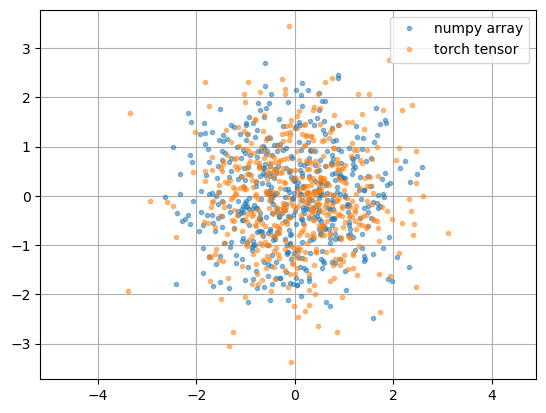

In [8]:
import matplotlib.pyplot as plt
plt.plot(arr[:, 0], arr[:, 1], '.', alpha=0.5, label="numpy array")
plt.plot(t2[:, 0], t2[:, 1], '.', alpha=0.5, label="torch tensor")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

In practice, the dataset we use is stored as numpy arrays. We convert the dateset to tensors load them on the GPU.

In [9]:
def np_to_torch(arr):

    return torch.tensor(arr.astype(np.float32))

### Data processing: train-test-split, dataset and dataloader.

The standard way to process data is to fo teh following:

1. Split the input dataset into training and validation sets.
2. Create TensorDataset for training and validation.
2. Create DataLoader for training and validation.

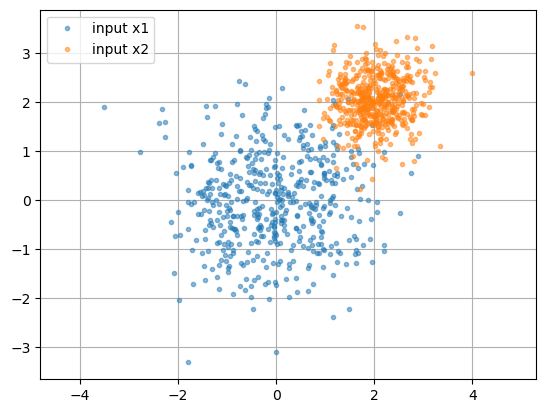

In [10]:
# First, create a dataset of gaussians using what we did above.

# Create an array called input_x which is the features of the traning set
# input_x consists of tow types of gaussians: input_x1 and input_x2

# input_x1 is 500 samples from a gaussian of N(0,1)
N_x1 = 500
input_x1 = np.random.normal(0, 1, (N_x1, 2)).astype(dtype=np.float32)

# input_x2 is 500 samples from a gaussian of N(2,0.5)
N_x2 = 500
input_x2 = np.random.normal(2, 0.5, (N_x2, 2)).astype(dtype=np.float32)

# Plot input_x1 and input_x2
plt.plot(input_x1[:, 0], input_x1[:, 1], '.', alpha=0.5, label="input x1")
plt.plot(input_x2[:, 0], input_x2[:, 1], '.', alpha=0.5, label="input x2")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

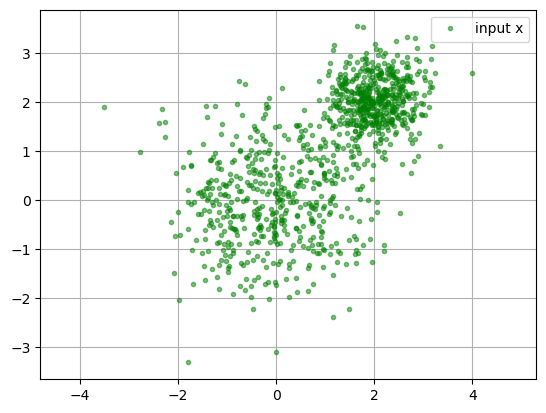

In [11]:
# create input_x which is a mixture of input_x1 and input_x2

input_x = np.concatenate([input_x1, input_x2], axis=0)

# Plot input_x

plt.plot(input_x[:, 0], input_x[:, 1], '.', c="green", alpha=0.5, label="input x")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

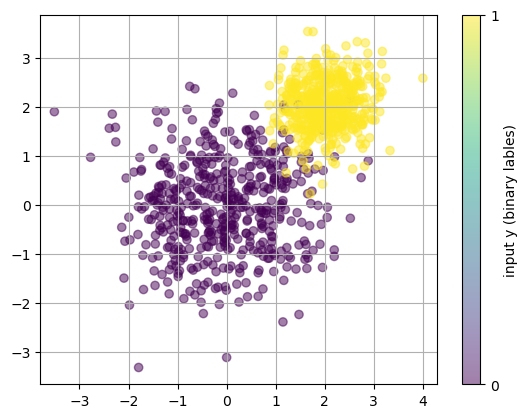

In [12]:
# create input_y which is the labels where input_x1 is labeled 0, and input_x2 is labeled 1

label_x1 = np.zeros(input_x1.shape[0])  # Assign label 0 to input_x1
label_x2 = np.ones(input_x2.shape[0])  # Assign label 1 to input_x2

input_y = np.concatenate([label_x1, label_x2], axis=0).reshape(-1, 1)

# Plot input_y on the z-axis

sc = plt.scatter(input_x[:, 0], input_x[:, 1], c=input_y.flatten(), cmap='viridis', alpha=0.5)
plt.axis('equal')
plt.grid()
cbar = plt.colorbar(sc, ticks=[0, 1]) # Set the colorbar ticks to only show 0 and 1
cbar.set_label('input y (binary lables)')
plt.show()

In [13]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [14]:
def process_data(input_x, input_y, batch_size):

    x_train, x_val, y_train, y_val = train_test_split(input_x, input_y, test_size=0.33, random_state=42)

    x_train = np_to_torch(x_train)
    y_train = np_to_torch(y_train)

    x_val = np_to_torch(x_val)
    y_val = np_to_torch(y_val)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader

### DNN Layers: input, hidden, activation

In [15]:
import torch.nn as nn

In [20]:
class Model(nn.Module):
    def __init__(self, layers, n_inputs, device="cpu"):
        super().__init__()

        layer_list = []
        for nodes in layers:
            layer_list.append(nn.Linear(n_inputs, nodes))
            layer_list.append(nn.ReLU())
            n_inputs = nodes
        layer_list.append(nn.Linear(n_inputs, 1))
        layer_list.append(nn.Sigmoid())
        
        self.model_stack = nn.Sequential(*layer_list)
        self.device = device

    def forward(self, x):
        return self.model_stack(x)

    def predict(self, x):
        with torch.no_grad():
            self.eval()
            x = torch.tensor(x, device=self.device)
            prediction = self.forward(x).detach().cpu().numpy()
        return prediction

### Loss functions and back propagation.

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from tqdm import tqdm
import yaml
import os

In [34]:
loss_func = F.binary_cross_entropy

### Training and validation loop

In [74]:
# First, initialize a model

n_inputs = 2
layers=[64,64,64]
device = "cpu"
model = Model(layers=layers, n_inputs=n_inputs).to(device)

# Define loss funtion and optimizer
loss_func = F.binary_cross_entropy       

# Creat an output directory

outdir="./"
os.makedirs(outdir, exist_ok=True)

In [75]:
# Define traning paramaters

n_epochs=20
batch_size=256
seed=1

learning_rate=1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

In [76]:
# Initialize training

update_epochs = 1
        
torch.manual_seed(seed)
np.random.seed(seed)

epochs, epochs_val = [], []
losses, losses_val = [], []

train_data, val_data = process_data(input_x, input_y, batch_size=batch_size)

100%|==========| 20/20 [00:00<00:00, 80.21it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

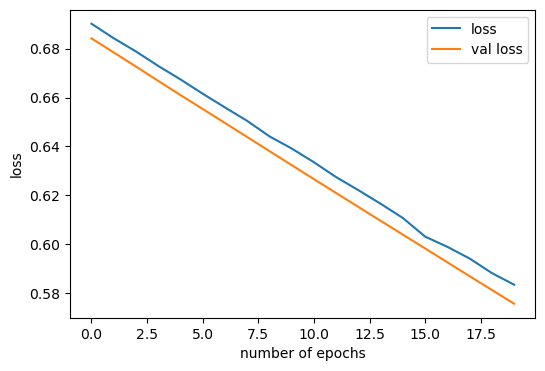

In [77]:
for epoch in tqdm(range(n_epochs), ascii=' >='):

    # Training

    losses_batch_per_e = []

    model.train()

    for batch_ndx, data in enumerate(train_data):

        batch_inputs, batch_labels = data
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        batch_outputs = model(batch_inputs)
        loss = loss_func(batch_outputs, batch_labels)
        losses_batch_per_e.append(loss.detach().cpu().numpy())
        mean_loss = np.mean(losses_batch_per_e)
        loss.backward()
        optimizer.step()

    epochs.append(epoch)
    losses.append(mean_loss)


    # Validation

    with torch.no_grad():

        model.eval()
        val_losses_batch_per_e = []

        for batch_ndx, data in enumerate(val_data):
            
            batch_inputs, batch_labels = data
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            batch_weights = None

            batch_outputs = model(batch_inputs)
            val_loss = loss_func(batch_outputs, batch_labels)
            val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

        epochs_val.append(epoch)
        mean_val_loss = np.mean(val_losses_batch_per_e)
        losses_val.append(mean_val_loss)

        # print(f"Epoch: {epoch} - loss: {mean_loss} - val loss: {mean_val_loss}")


plt.figure(figsize=(6,4))
plt.plot(epochs, losses, label="loss")
plt.plot(epochs_val, losses_val, label="val loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show

### Prediction: evaluate the trained model

In [78]:
def evaluation(model, X_test,y_test=None):

    model.eval()

    with torch.no_grad():
        x_test = np_to_torch(X_test).to(device)
        outputs = model(x_test).detach().cpu().numpy()

        # calculate auc 
        if y_test is not None:
            auc = roc_auc_score(y_test, outputs)
            fpr, tpr, _ = roc_curve(y_test, outputs)

    if y_test is not None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(fpr, tpr, label=f"AUC: {auc:.3f}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"ROC curve")
        ax.plot([0,1],[0,1],color="gray",ls=":",label="Random")
        ax.legend()

        if auc < 0.5:
            auc = 1.0 - auc

        print(f"AUC: {auc}.")

    return outputs

AUC: 0.9963040000000001.


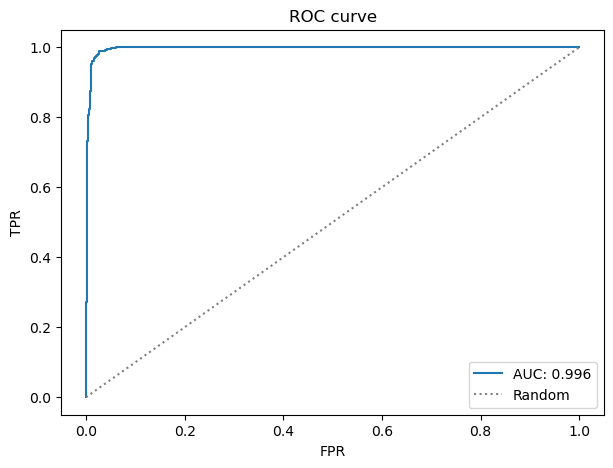

In [66]:
output = evaluation(model, input_x, input_y)